In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import os
import numpy as np

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [3]:
device = torch.device(torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu"))

In [4]:
data_dir = 'hymenoptera_data'

image_datasets = { x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = { x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=4,
                                              shuffle=True) for x in ['train', 'val']}

dataset_sizes = { x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

print(f"Class names: {class_names}")
print(f"Training batches: {len(dataloaders['train'])}")
print(f"Test batches: {len(dataloaders['val'])}")
print(f"Training images: {dataset_sizes['train']}")
print(f"Test images: {dataset_sizes['val']}")

Class names: ['ants', 'bees']
Training batches: 63
Test batches: 39
Training images: 250
Test images: 153


In [5]:
model_resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT).to(device)

In [6]:
print(len(list(model_resnet.parameters())))
for param in model_resnet.parameters():
    param.requires_grad = False

62


In [7]:
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 2).to(device)

In [8]:
# Training

iteration = 0
correct = 0

for inputs, labels in dataloaders['train']:
    if iteration == 1:  # Let's visualize it for the first batch in our training data
        break
    
    inputs = Variable(inputs).to(device)
    labels = Variable(labels).to(device)

    print("For one iteration, this is what happens:")
    print("Input Shape:", inputs.shape)
    print("Labels Shape:", labels.shape)
    print("Labels are: {}".format(labels))
    output = model_resnet(inputs)
    print("Output Tensor:", output)
    print("Outputs Shape", output.shape)
    _, predicted = torch.max(output, 1)
    print("Predicted:", predicted)
    print("Predicted Shape", predicted.shape)
    correct += (predicted == labels).sum()   
    print("Correct Predictions:", correct)
    
    iteration += 1

For one iteration, this is what happens:
Input Shape: torch.Size([4, 3, 224, 224])
Labels Shape: torch.Size([4])
Labels are: tensor([0, 0, 0, 1], device='mps:0')
Output Tensor: tensor([[ 0.5789,  0.1741],
        [ 1.3863, -0.5363],
        [ 1.6007, -0.9763],
        [ 1.3586, -0.0263]], device='mps:0', grad_fn=<LinearBackward0>)
Outputs Shape torch.Size([4, 2])
Predicted: tensor([0, 0, 0, 0], device='mps:0')
Predicted Shape torch.Size([4])
Correct Predictions: tensor(3, device='mps:0')


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [10]:
num_epochs = 25
for epoch in range(num_epochs):

    correct = 0
    for images, labels in dataloaders['train']:
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()

    exp_lr_scheduler.step()
    
    train_acc = 100 * (correct / dataset_sizes['train'])
    print("Epoch [{}/{}], Loss: {:.4f}, Accuracy: {}%".format(epoch + 1, num_epochs, loss.item(), train_acc))

Epoch [1/25], Loss: 0.4512, Accuracy: 68.0%
Epoch [2/25], Loss: 0.5469, Accuracy: 71.5999984741211%
Epoch [3/25], Loss: 0.2076, Accuracy: 72.0%
Epoch [4/25], Loss: 0.6124, Accuracy: 75.19999694824219%
Epoch [5/25], Loss: 0.0095, Accuracy: 75.5999984741211%
Epoch [6/25], Loss: 2.3264, Accuracy: 80.80000305175781%
Epoch [7/25], Loss: 0.9746, Accuracy: 74.80000305175781%
Epoch [8/25], Loss: 0.9147, Accuracy: 84.4000015258789%
Epoch [9/25], Loss: 1.1648, Accuracy: 83.60000610351562%
Epoch [10/25], Loss: 0.0049, Accuracy: 84.79999542236328%
Epoch [11/25], Loss: 0.0635, Accuracy: 82.80000305175781%
Epoch [12/25], Loss: 0.8249, Accuracy: 88.0%
Epoch [13/25], Loss: 0.1855, Accuracy: 85.5999984741211%
Epoch [14/25], Loss: 0.8237, Accuracy: 88.0%
Epoch [15/25], Loss: 0.6482, Accuracy: 84.79999542236328%
Epoch [16/25], Loss: 0.7668, Accuracy: 84.4000015258789%
Epoch [17/25], Loss: 1.1657, Accuracy: 86.79999542236328%
Epoch [18/25], Loss: 0.0840, Accuracy: 84.79999542236328%
Epoch [19/25], Loss: 0

In [11]:
# Testing the model

model_resnet.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for (images, labels) in dataloaders['val']:
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        outputs = model_resnet(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum()

    print("Test Accuracy: {:.3f}%".format(100 * correct / total))

Test Accuracy: 94.771%


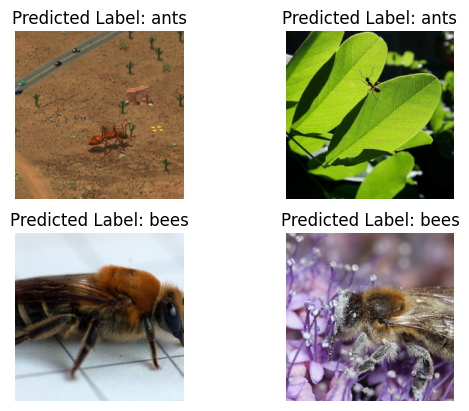

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
shown_batch = 0
index = 0

with torch.no_grad():
    for (images, labels) in dataloaders['val']:
        if shown_batch == 1:  # Let's only show images and their predictions for the first batch in our validation data
            break
        shown_batch += 1
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        outputs = model_resnet(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(4):
            index += 1
            ax = plt.subplot(2, 2, index)
            ax.axis('off')
            ax.set_title(f'Predicted Label: {class_names[predicted[i]]}')
            input_img = images.cpu().data[i]
            inp = input_img.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            plt.imshow(inp)